In [25]:
import pandas as pd
import re
from pprint import pprint
import networkx as nx
import matplotlib.pyplot as plt
from openai import OpenAI
import json
import os

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

### 数据处理 ###

In [26]:
# 数据读取
dataset = pd.read_csv('processed_job_details.csv')  # 读取预处理后的职位详情数据

# 筛选包含特定关键词的职位数据
filtered_data = dataset[dataset['name'].str.contains(r'(?=.*AI)(?=.*产品)|(?=.*大模型)(?=.*产品)', flags=re.IGNORECASE, regex=True)].reset_index(drop=True)
# 筛选不包含特定关键词的职位数据
rest_data = dataset[~dataset['name'].str.contains(r'(?=.*AI)(?=.*产品)|(?=.*大模型)(?=.*产品)', flags=re.IGNORECASE, regex=True)].reset_index(drop=True)

# 过滤掉美团非实习岗位
filtered_data = filtered_data[~((filtered_data['company'] == 'meituan') & (~filtered_data['name'].str.contains('实习')))]
# 过滤掉网易非实习岗位
filtered_data = filtered_data[~((filtered_data['company'] == 'wangyi') & (~filtered_data['name'].str.contains('实习')))]

# 查看筛选后的数据
filtered_data.head()

,name,requirement,description,company
0,AI应用产品经理,1、负责过国际化/出海，具有SaaS/开发者相关产品的经历；\n2、有使用Cursor、Wi...,1、负责AI应用开发平台的产品规划与需求管理，制定并推进产品路线图；\n2、与技术团队紧密协...,aliyun
1,AI大模型产品经理实习生-飞书,1、2026届硕士及以上学位在读，计算机、人工智能专业优先；\n2、扎实的深度学习技术基础，...,ByteIntern：面向2026届毕业生（2025年9月-2026年8月期间毕业），为符合...,bytedance
2,AI智能客服产品经理实习生-国际化,1、本科及以上学历在读，小语种相关专业优先；\n2、有AI大模型相关产品经历优先；\n3、具...,日常实习：面向全体在校生，为符合岗位要求的同学提供为期3个月及以上的项目实践机会。\n团队介...,bytedance
3,AI大模型产品经理实习生-飞书,1、2026届硕士及以上学位在读，计算机、人工智能专业优先；\n2、扎实的深度学习技术基础，...,ByteIntern：面向2026届毕业生（2025年9月-2026年8月期间毕业），为符合...,bytedance
4,AI产品实习生-飞书,1、2026届硕士及以上学位在读，计算机、软件工程等相关专业优先；\n2、善于逻辑思维推导，...,ByteIntern：面向2026届毕业生(2025年9月-2026年8月期间毕业)，为符合...,bytedance


<Axes: xlabel='company'>

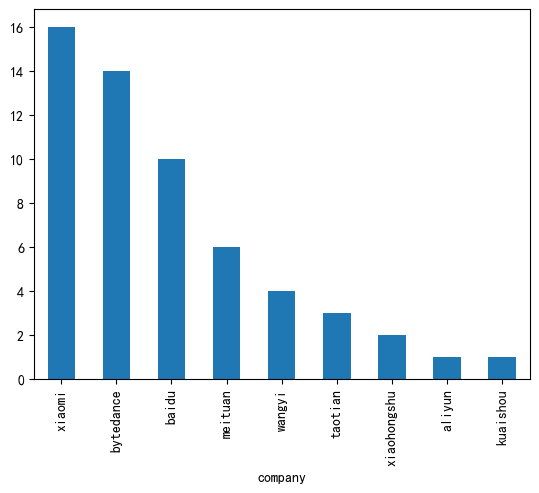

In [27]:
filtered_data['company'].value_counts().plot(kind='bar')

### 大模型实体及关系抽取和可视化 ###

In [8]:
from dotenv import load_dotenv

def extract_entities_and_relations(text, model_choice):
    """
    从文本中提取实体和关系
    :param text: 输入的文本
    :param model_choice: 模型选择，'deepseek' 或 'qwen'
    """
    # 加载 .env 文件中的环境变量
    load_dotenv()

    api_key = os.getenv("API_KEY")
    base_url = os.getenv("BASE_URL")
    model_name = os.getenv("MODEL_NAME")

    if not api_key or not base_url or not model_name:
        raise EnvironmentError("请确保 .env 文件中正确设置了 API_KEY, BASE_URL 和 MODEL_NAME")

    if not api_key or not base_url or not model_name:
        raise EnvironmentError("请确保环境变量 API_KEY, BASE_URL 和 MODEL_NAME 已正确设置")

    client = OpenAI(api_key=api_key, base_url=base_url)

    if model_choice == 'deepseek':
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "请你完成命名实体识别任务，将所提供的文本中的实体以及实体关系识别出来，然后以 [{'实体1': 'AIGC', '实体2': 'AI产品应用', '实体关系': '从业经验'}, {'实体1': 'LLM', '实体2': 'AIGC', '实体关系': '核心原理'}]的json格式严格输出，在所给定文本中所有的三元组，除了输出三元组结果，不要输出其他内容"},
                {"role": "user", "content": f"从以下文本中抽取实体以及实体关系: {text}"},
            ],
            stream=False
        )
        result = response.choices[0].message.content

    elif model_choice == 'qwen':
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {'role': 'system', 'content': '请你完成命名实体识别任务，将所提供的文本中的实体以及实体关系识别出来，然后以 [{"实体1": "AIGC", "实体2": "AI产品应用", "实体关系": "从业经验"}, {"实体1": "LLM", "实体2": "AIGC", "实体关系": "核心原理"}]的json格式严格输出，在所给定文本中所有的三元组，除了输出三元组结果，不要输出其他内容'},
                {'role': 'user', 'content': f'从以下文本中抽取实体以及实体关系: {text}'}
            ]
        )
        result = response.choices[0].message.content
    else:
        raise ValueError("Invalid model choice. Please choose either 'deepseek' or 'qwen'.")

    return result

def visualize_graph(subjects, relations, objects, min_degree=2):
    """
    可视化三元组图，接受三个列表作为输入，并去掉度较小的节点及其对应的关系以强调重点
    """
    G = nx.DiGraph()

    # 添加实体为节点
    for subj, obj in zip(subjects, objects):
        G.add_node(subj)
        G.add_node(obj)

    # 添加关系为边
    for subj, verb, obj in zip(subjects, relations, objects):
        G.add_edge(subj, obj, label=verb)

    # 计算节点的度
    degrees = dict(G.degree())

    # 去掉度小于 min_degree 的节点
    nodes_to_remove = [node for node, degree in degrees.items() if degree < min_degree]
    G.remove_nodes_from(nodes_to_remove)

    # 去掉与被移除节点相关的边
    edges_to_remove = [(u, v) for u, v in G.edges if u in nodes_to_remove or v in nodes_to_remove]
    G.remove_edges_from(edges_to_remove)

    # 使用 spring_layout 布局避免节点重叠
    pos = nx.spring_layout(G, k=1, seed=42)  # 调整 k 值控制节点间距
    plt.figure(figsize=(25, 20))

    # 绘制节点，节点大小根据度计算
    node_sizes = [v * 200 for node, v in degrees.items() if node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black", font_weight="bold")

    # 绘制边
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, edge_color="gray", connectionstyle="arc3,rad=0.2")
    
    # 绘制边标签，避免重叠
    edge_labels = nx.get_edge_attributes(G, "label")
    adjusted_pos = {key: (value[0], value[1] + 0.05) for key, value in pos.items()}  # 调整标签位置
    nx.draw_networkx_edge_labels(G, adjusted_pos, edge_labels=edge_labels, font_color="darkgreen", font_size=9, bbox=dict(alpha=0))

    plt.title("Triple Graph", fontsize=16)
    plt.axis("off")
    plt.show()

In [9]:
requirement_triples = []

for index,requirement in enumerate(filtered_data['requirement']):
    result_dict = extract_entities_and_relations(requirement,'qwen')
    triples = json.loads(result_dict.replace("'", '"'))
    print(triples)
    requirement_triples.extend(triples)
    print(f"第{index+1}个实体及关系抽取完成")

with open('requirement_triples.json', "w", encoding="utf-8") as f:
    json.dump(requirement_triples, f, ensure_ascii=False, indent=4)

[{'实体1': '国际化/出海', '实体2': 'SaaS/开发者相关产品', '实体关系': '经历'}, {'实体1': 'Cursor', '实体2': 'AI编程产品', '实体关系': '经验'}, {'实体1': 'Windsurf', '实体2': 'AI编程产品', '实体关系': '经验'}, {'实体1': 'V0.dev', '实体2': 'AI编程产品', '实体关系': '经验'}, {'实体1': 'bolt.new', '实体2': 'AI编程产品', '实体关系': '经验'}, {'实体1': 'Devin', '实体2': 'AI编程产品', '实体关系': '经验'}, {'实体1': '新技术趋势', '实体2': 'AI工具', '实体关系': '构建应用经验'}, {'实体1': 'AI工具', '实体2': '优劣及可改进点', '实体关系': '识别'}]
第1个实体及关系抽取完成
[{'实体1': '硕士', '实体2': '计算机', '实体关系': '专业'}, {'实体1': '硕士', '实体2': '人工智能', '实体关系': '专业'}, {'实体1': '深度学习', '实体2': '大语言模型', '实体关系': '项目经验'}, {'实体1': '深度学习', '实体2': '多模态', '实体关系': '项目经验'}, {'实体1': '深度学习', '实体2': '大模型', '实体关系': '评测经验'}, {'实体1': 'Python', '实体2': '编程语言', '实体关系': '掌握'}, {'实体1': 'C++', '实体2': '编程语言', '实体关系': '掌握'}, {'实体1': 'Pytorch', '实体2': '训练框架', '实体关系': '熟练'}, {'实体1': 'Tensorflow', '实体2': '训练框架', '实体关系': '熟练'}, {'实体1': '产品意识', '实体2': '业务产品需求', '实体关系': '理解'}, {'实体1': '项目管理能力', '实体2': '协同能力', '实体关系': '并列'}, {'实体1': '项目管理能力', '实体2': '数据洞察能力', '实体关系': '并列'}]
第2个实体及

In [10]:
description_triples = []

for index,description in enumerate(filtered_data['description']):
	result_dict = extract_entities_and_relations(description,'qwen')
	triples = json.loads(result_dict.replace("'", '"'))
	print(triples)
	description_triples.extend(triples)
	print(f"第{index+1}个实体及关系抽取完成")

with open('description_triples.json', "w", encoding="utf-8") as f:
	json.dump(description_triples, f, ensure_ascii=False, indent=4)


第1个实体及关系抽取完成
第2个实体及关系抽取完成
第3个实体及关系抽取完成
第4个实体及关系抽取完成
第5个实体及关系抽取完成
第6个实体及关系抽取完成
第7个实体及关系抽取完成
第8个实体及关系抽取完成
第9个实体及关系抽取完成
第10个实体及关系抽取完成
第11个实体及关系抽取完成
第12个实体及关系抽取完成
第13个实体及关系抽取完成
第14个实体及关系抽取完成
第15个实体及关系抽取完成
第16个实体及关系抽取完成
第17个实体及关系抽取完成
第18个实体及关系抽取完成
第19个实体及关系抽取完成
第20个实体及关系抽取完成
第21个实体及关系抽取完成
第22个实体及关系抽取完成
第23个实体及关系抽取完成
第24个实体及关系抽取完成
第25个实体及关系抽取完成
第26个实体及关系抽取完成
第27个实体及关系抽取完成
第28个实体及关系抽取完成
第29个实体及关系抽取完成
第30个实体及关系抽取完成
第31个实体及关系抽取完成
第32个实体及关系抽取完成
第33个实体及关系抽取完成
第34个实体及关系抽取完成
第35个实体及关系抽取完成
第36个实体及关系抽取完成
第37个实体及关系抽取完成
第38个实体及关系抽取完成
第39个实体及关系抽取完成
第40个实体及关系抽取完成
第41个实体及关系抽取完成
第42个实体及关系抽取完成
第43个实体及关系抽取完成
第44个实体及关系抽取完成
第45个实体及关系抽取完成
第46个实体及关系抽取完成
第47个实体及关系抽取完成
第48个实体及关系抽取完成
第49个实体及关系抽取完成
第50个实体及关系抽取完成
第51个实体及关系抽取完成
第52个实体及关系抽取完成
第53个实体及关系抽取完成
第54个实体及关系抽取完成
第55个实体及关系抽取完成
第56个实体及关系抽取完成
第57个实体及关系抽取完成


In [11]:
with open('requirement_triples.json', "r", encoding="utf-8") as f:
    requirement_triples = json.load(f)

with open('description_triples.json', "r", encoding="utf-8") as f:
    description_triples = json.load(f)

requirement_dataset = pd.DataFrame(requirement_triples)
description_dataset = pd.DataFrame(description_triples)

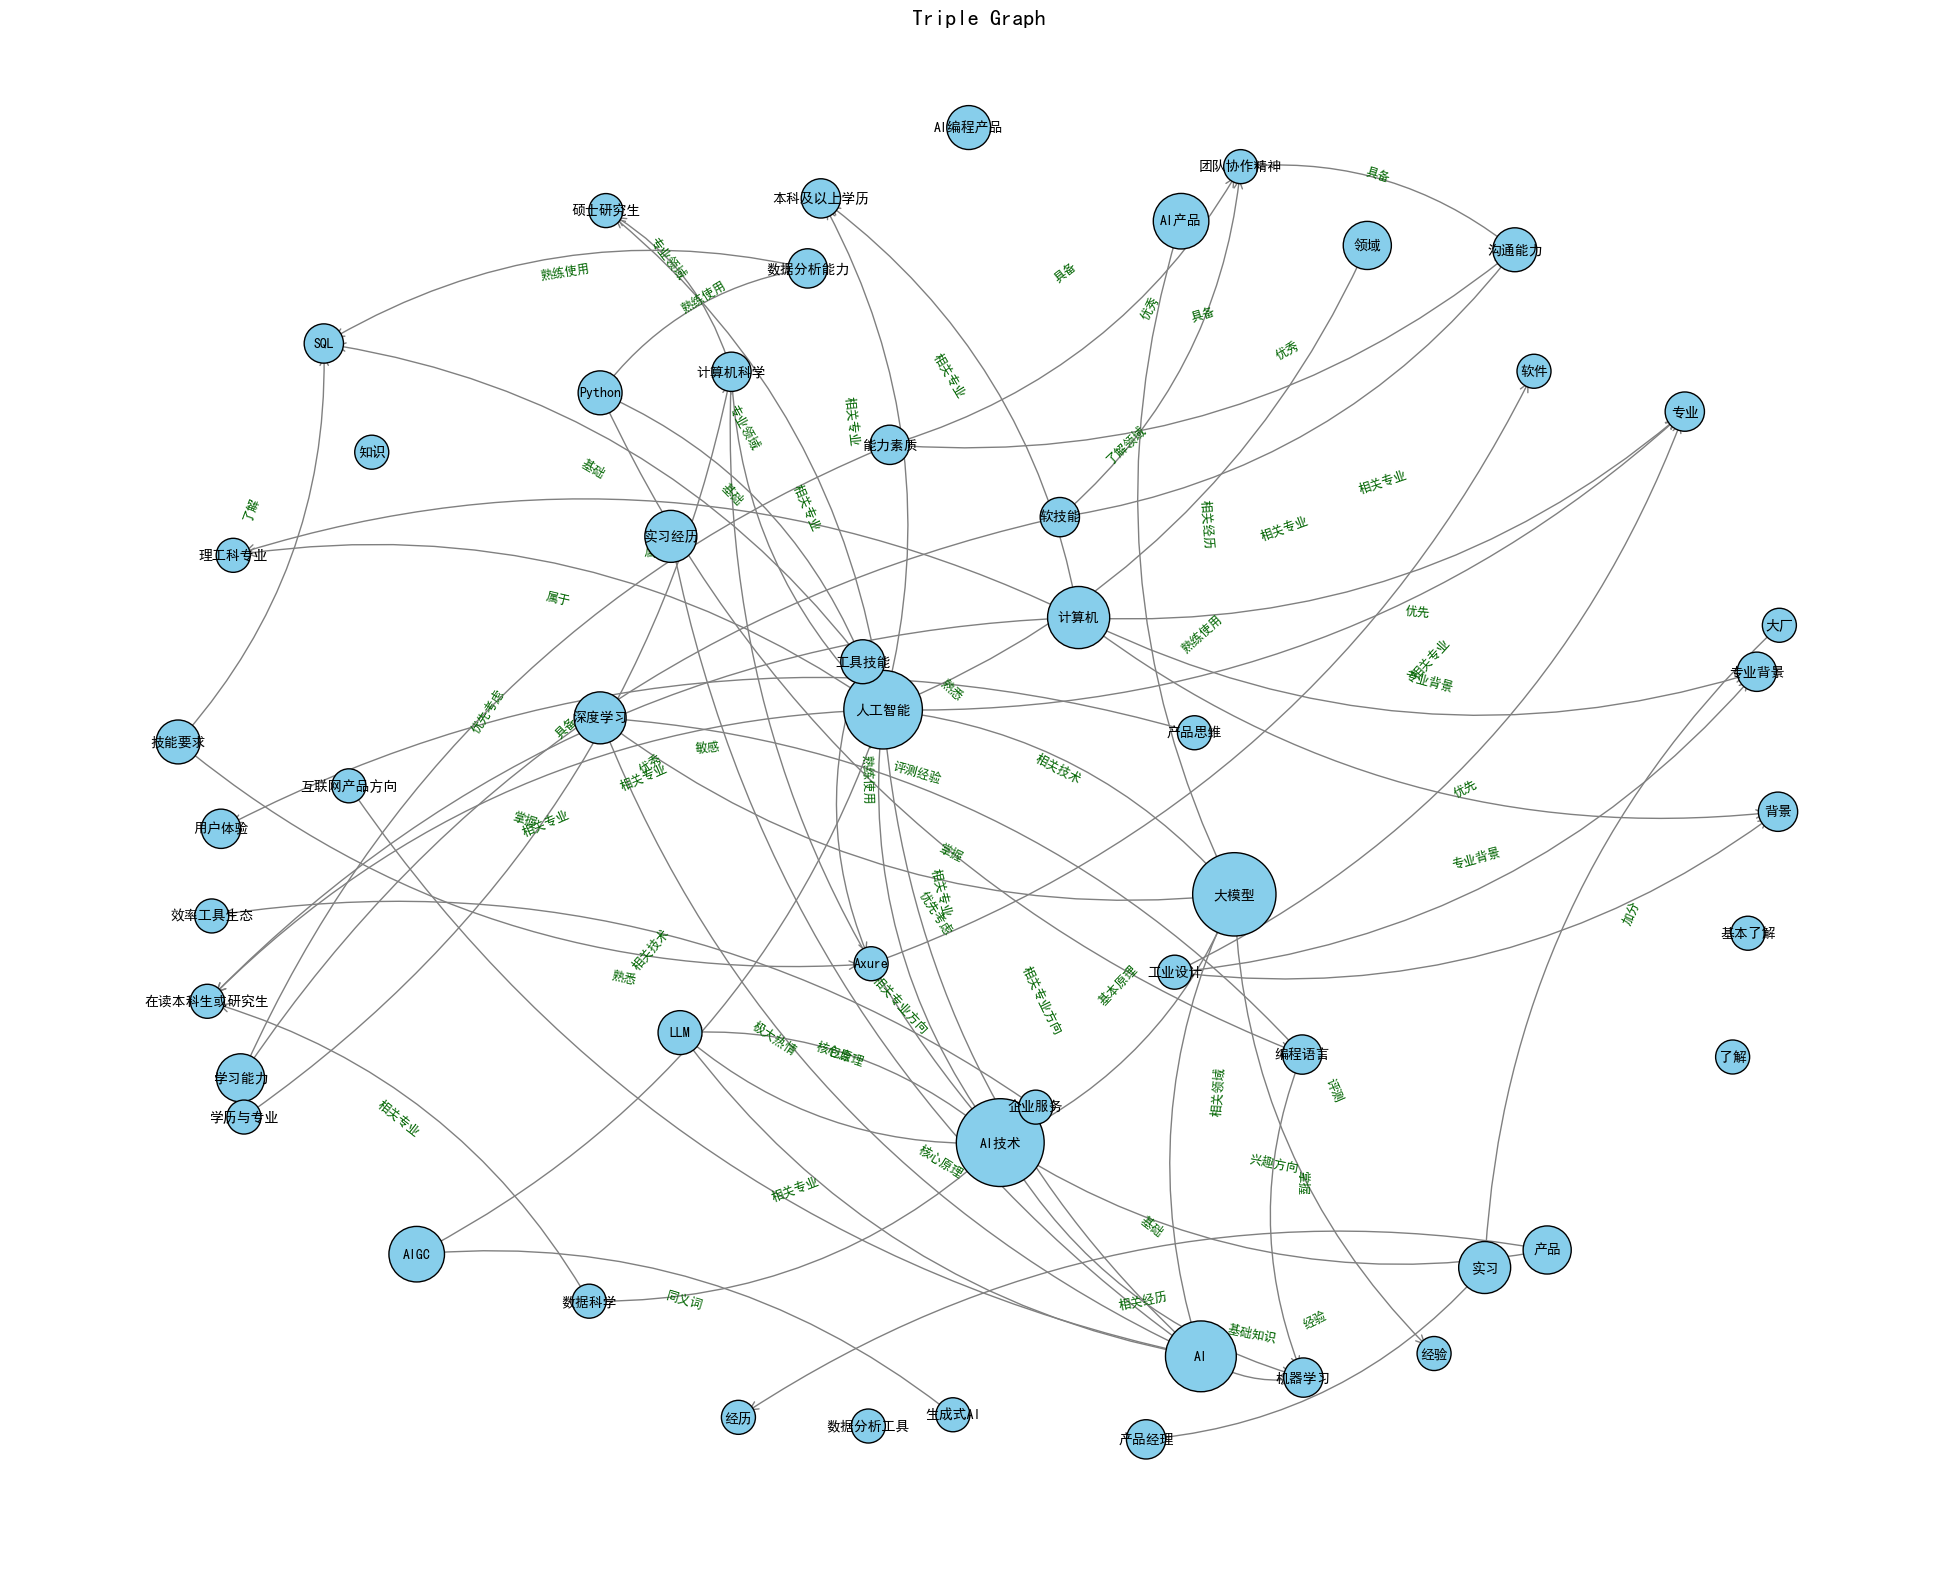

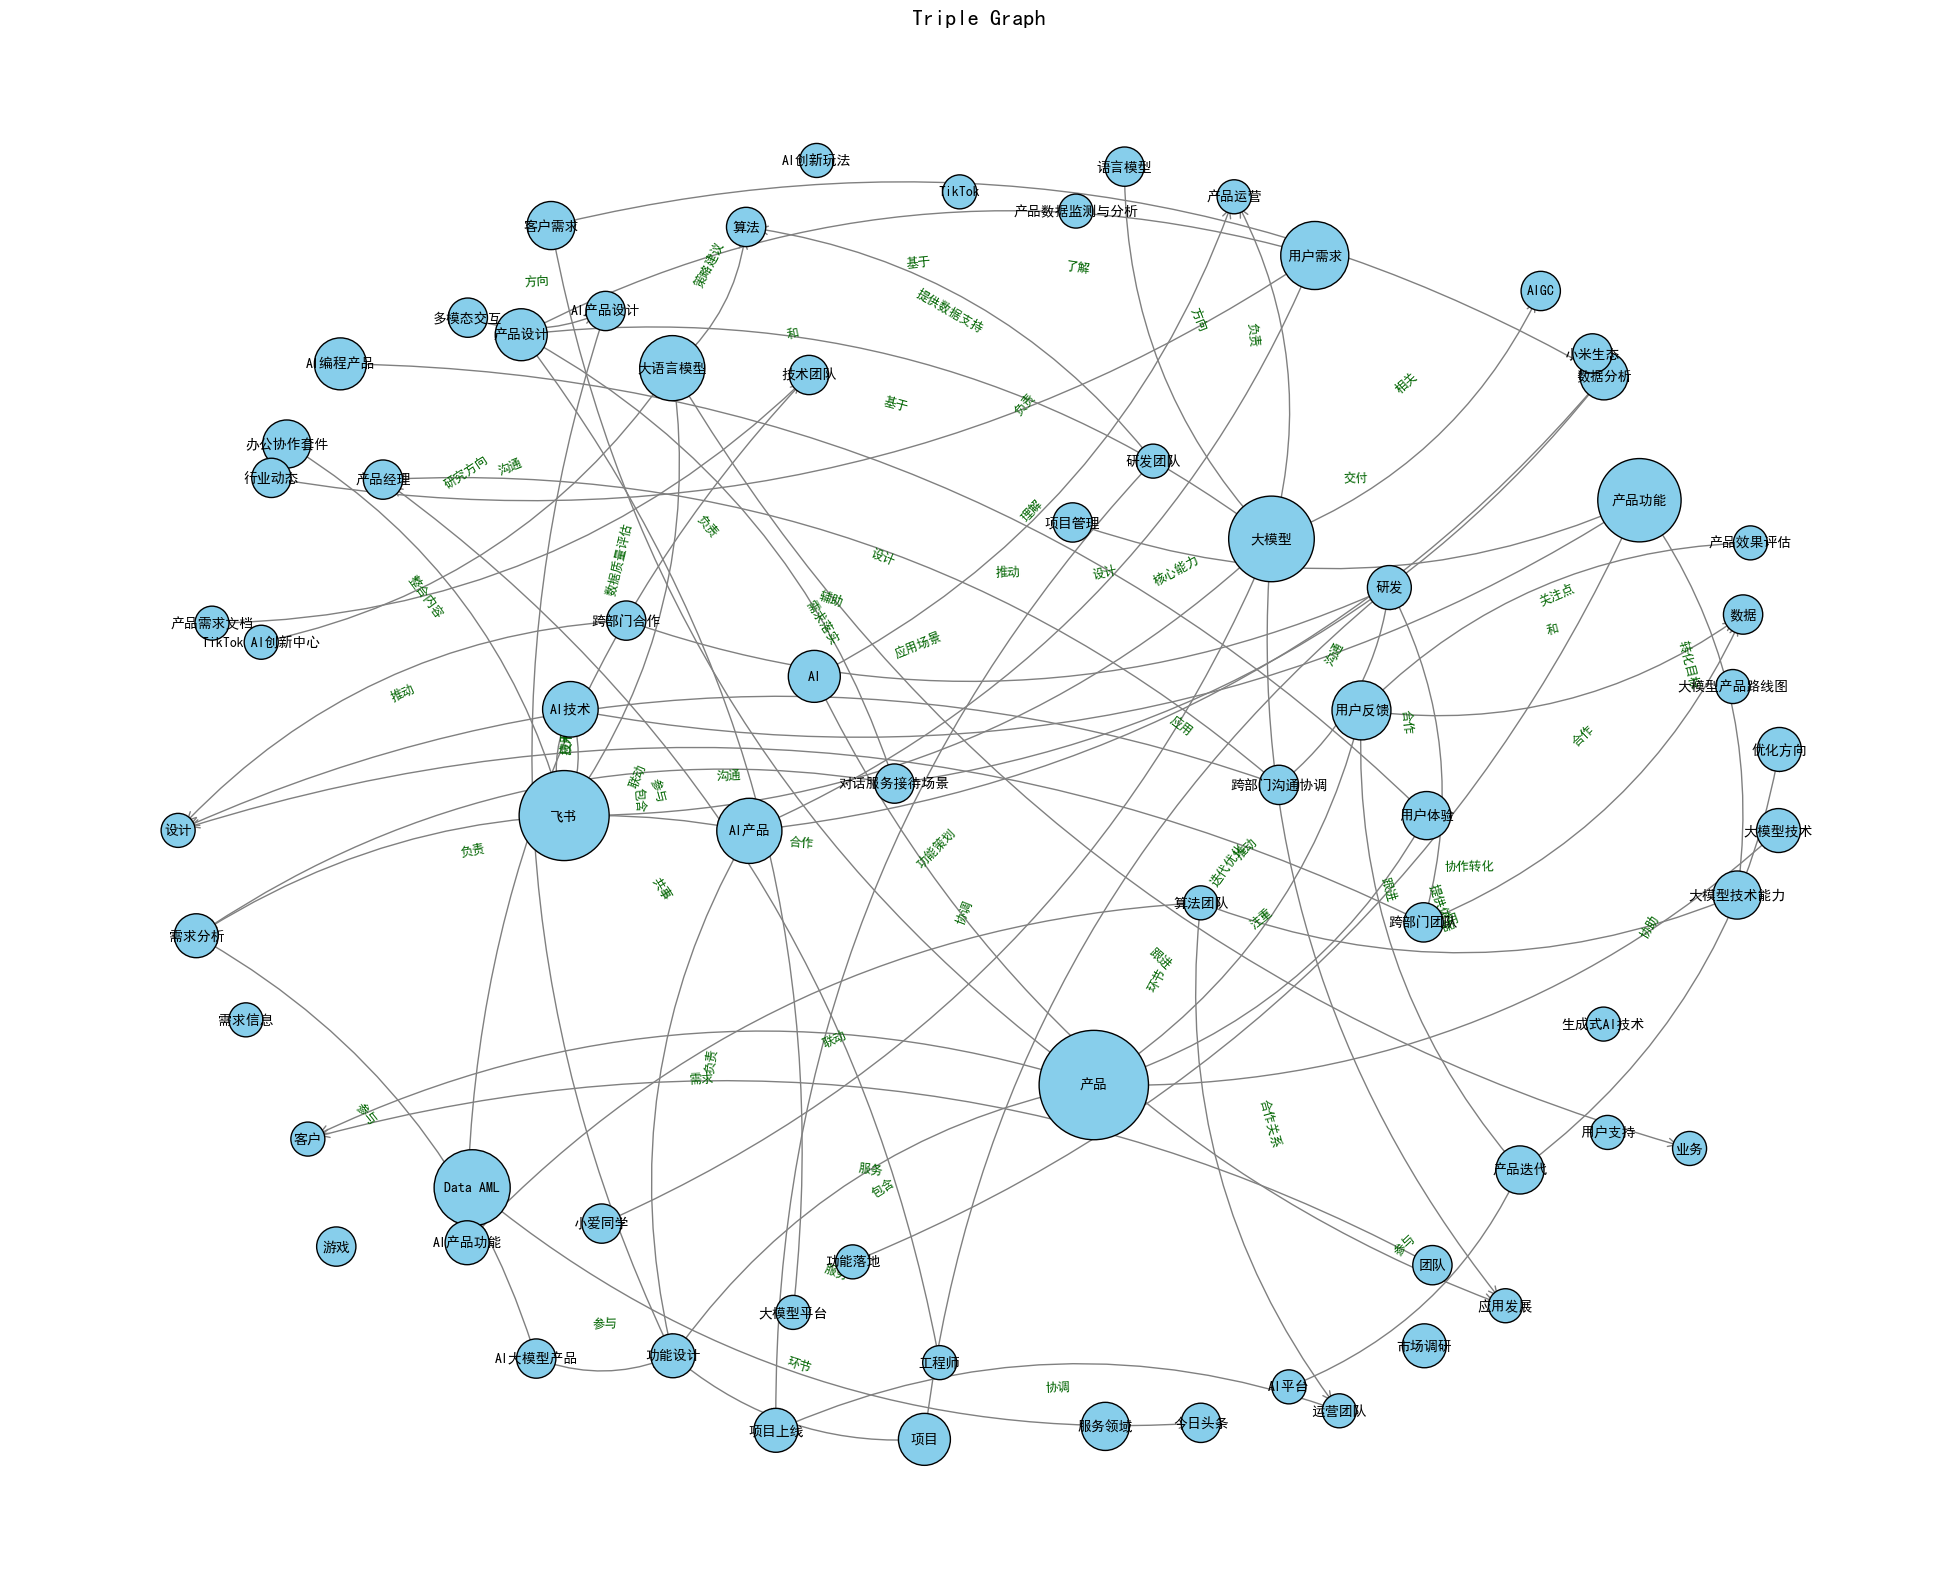

In [12]:
visualize_graph(requirement_dataset['实体1'], requirement_dataset['实体关系'], requirement_dataset['实体2'], min_degree=3)
visualize_graph(description_dataset['实体1'], description_dataset['实体关系'], description_dataset['实体2'], min_degree=3)

### embed文本降维进行可视化

In [28]:
# 数据处理
# 将'requirement'和'description'列中的字符串按换行符分割成列表
filtered_data['requirement'] = filtered_data['requirement'].str.split('\n')
filtered_data['description'] = filtered_data['description'].str.split('\n')

# 删除'name,company'列重复的行，并重置索引
filtered_data.drop_duplicates(subset=['name','company'], inplace=True)
filtered_data.reset_index(drop=True, inplace=True)

# 初始化空的DataFrame，用于存储拆分后的'requirement'和'description'数据
requirement_dataset = pd.DataFrame(columns=['name', 'company', 'requirement'])
description_dataset = pd.DataFrame(columns=['name', 'company', 'description'])

# 用于存储拆分后的'requirement'和'description'行数据的列表
requirement_rows = []
description_rows = []

# 遍历每一行数据，将'requirement'列中的每个非空条目拆分成单独的行
for index, row in filtered_data.iterrows():
    for i in range(len(row['requirement'])):
        if row['requirement'][i].strip() == '':  # 跳过空字符串
            continue
        requirement_rows.append({'name': row['name'], 'company': row['company'], 'requirement': row['requirement'][i]})

# 遍历每一行数据，将'description'列中的每个非空条目拆分成单独的行
for index, row in filtered_data.iterrows():
    for i in range(len(row['description'])):
        if row['description'][i].strip() == '':  # 跳过空字符串
            continue
        description_rows.append({'name': row['name'], 'company': row['company'], 'description': row['description'][i]})

# 将拆分后的'requirement'和'description'行数据添加到对应的DataFrame中
requirement_dataset = pd.concat([requirement_dataset, pd.DataFrame(requirement_rows)], ignore_index=True)
description_dataset = pd.concat([description_dataset, pd.DataFrame(description_rows)], ignore_index=True)

# 删除'requirement'和'description'列中的重复值，并重置索引
requirement_dataset = requirement_dataset.drop_duplicates(subset=['requirement']).reset_index(drop=True)
description_dataset = description_dataset.drop_duplicates(subset=['description']).reset_index(drop=True)


In [34]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
import umap
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

# 检查是否有可用的 GPU，并设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 初始化预训练模型和分词器
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v3', trust_remote_code=True).to(device)  # 加载模型并移动到设备
tokenizer = AutoTokenizer.from_pretrained('jinaai/jina-embeddings-v3', trust_remote_code=True)  # 加载分词器

# 假设 requirement_dataset 和 description_dataset 已定义
requirement_texts = requirement_dataset['requirement'].tolist()  # 提取需求文本
description_texts = description_dataset['description'].tolist()  # 提取描述文本

# 定义生成嵌入向量的函数
def generate_embeddings(texts):
    """
    使用预训练模型为文本列表生成嵌入向量。
    :param texts: 输入文本列表
    :return: 嵌入向量的 Numpy 数组
    """
    with torch.no_grad():  # 禁用梯度计算以节省内存
        # 对输入文本进行分词，并将其移动到指定设备
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
        outputs = model(**inputs)  # 获取模型输出
        embedding = outputs.last_hidden_state.mean(dim=1)  # 取最后一层隐藏状态的均值作为嵌入向量
        embeddings = embedding.to(dtype=torch.float32).cpu().numpy()  # 转换为 Numpy 数组并移动到 CPU
    return embeddings

# 定义处理文本并进行可视化交互的函数
def process_texts_and_visualize_interactive(texts, store_name: str, cluster_num=10,dimension=3, n=3):
    """
    处理文本以生成嵌入向量、降维、聚类并进行交互式可视化。
    
    :param texts: 输入文本列表
    :param store_name: 保存可视化文件的名称
    :param dimension: UMAP 降维的维度（支持 2 或 3）
    :param n: 每个聚类中心最近的文本数量
    :return: 包含每个聚类中心最近文本的字典
    """
    # 第一步：生成嵌入向量
    embeddings = generate_embeddings(texts)
    print(f"嵌入向量的形状: {embeddings.shape}")

    # 第二步：使用 UMAP 进行降维（在 CPU 上执行）
    umap_model = umap.UMAP(n_components=dimension, random_state=42)  # 设置降维维度
    reduced_embeddings = umap_model.fit_transform(embeddings)  # 执行降维
    print(f"降维后的嵌入向量形状: {reduced_embeddings.shape}")

    # 第三步：使用 KMeans 进行聚类（在 CPU 上执行）
    kmeans = KMeans(n_clusters=cluster_num, random_state=42)  # 设置聚类数量
    clusters = kmeans.fit_predict(reduced_embeddings)  # 执行聚类
    print(f"聚类结果的形状: {clusters.shape}")

    # 第四步：可视化
    if dimension == 3:  # 如果降维到 3D
        import plotly.express as px  # 导入 Plotly 用于交互式 3D 可视化
        fig = px.scatter_3d(
            x=reduced_embeddings[:, 0],
            y=reduced_embeddings[:, 1],
            z=reduced_embeddings[:, 2],
            color=clusters.astype(str),  # 使用聚类结果进行着色
            hover_name=texts,  # 悬停时显示文本
            title="聚类的交互式 3D 可视化",
            labels={'x': 'UMAP 维度 1', 'y': 'UMAP 维度 2', 'z': 'UMAP 维度 3'}
        )
        fig.update_traces(marker=dict(size=5))  # 设置点的大小
        fig.show()  # 显示图形
        fig.write_html(f'{store_name}_visual.html')  # 保存为 HTML 文件
    elif dimension == 2:  # 如果降维到 2D
        plt.figure(figsize=(10, 8))  # 设置图形大小
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', s=10)  # 绘制散点图
        plt.colorbar(label='聚类')  # 添加颜色条
        plt.title("聚类的 2D 可视化")  # 设置标题
        plt.xlabel("UMAP 维度 1")  # 设置 X 轴标签
        plt.ylabel("UMAP 维度 2")  # 设置 Y 轴标签
        plt.savefig(f'{store_name}_visual.png')  # 保存为 PNG 文件
        plt.show()  # 显示图形
    else:
        print(f"不支持 dimension={dimension} 的可视化。")

    # 第五步：找到每个聚类中心最近的文本
    cluster_centers = {}
    for cluster_id in np.unique(clusters):  # 遍历每个聚类
        cluster_mask = clusters == cluster_id  # 获取属于当前聚类的样本
        cluster_center = np.mean(embeddings[cluster_mask], axis=0)  # 计算当前聚类的中心
        distances = np.linalg.norm(embeddings - cluster_center, axis=1)  # 计算每个样本到聚类中心的距离
        nearest_indices = np.argsort(distances)[:n]  # 找到距离最近的 n 个样本
        cluster_centers[cluster_id] = [texts[idx] for idx in nearest_indices]  # 保存最近的文本

    # # 打印每个聚类中心最近的文本
    # print("每个聚类中心最近的文本:")
    # for cluster_id, nearest_texts in cluster_centers.items():
    #     print(f"聚类 {cluster_id}: {nearest_texts}")

    return cluster_centers

使用设备: cuda


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

In [36]:
requirment_cluster_centers = process_texts_and_visualize_interactive(requirement_texts,'requirement',cluster_num=10,dimension=3,n=3)
pprint(requirment_cluster_centers)
description_cluster_centers = process_texts_and_visualize_interactive(description_texts,'description',cluster_num=10,dimension=3,n=3)
pprint(description_cluster_centers)

嵌入向量的形状: (228, 1024)


c:\Users\20137\anaconda3\envs\yuan\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



降维后的嵌入向量形状: (228, 3)
聚类结果的形状: (228,)


{0: ['1、对AI产品有强烈兴趣，了解大模型基础概念，有ChatGPT等大模型工具使用经验；',
     '2、对人工智能前沿技术如大模型、AIGC等有浓厚兴趣，并有一定的了解；',
     '2. 具备扎实的技术基础，对生成式AI和多模态大模型技术与应用充满热情；'],
 1: ['2.分析能力 ：具备良好的数据分析能力，能够从大量数据中提取有价值的信息，为产品决策提供依据。',
     '2.具备较强的数据分析和问题解决能力，能够通过行业调研、数据分析和用户回访等手段梳理产品的优化思路；',
     '3. 具备优秀的数据分析能力，熟练使用SQL/Python进行基础数据处理，能用数据驱动产品决策。'],
 2: ['4、每周需到岗5天，实习期半年以上优先。',
     '4、每周到岗5天，实习期半年以上优先。',
     '1.本科及以上学历，每周至少可实习4天，实习时长3个月及以上，长期实习优先'],
 3: ['4、良好的交流与团队协作能力，责任心强，具备较强自驱力。',
     '3、具备较强的沟通协调能力，拥有强烈的责任心和团队合作精神，出色的学习能力；',
     '1、具备优秀的沟通协调能力、良好的团队合作精神，学习能力强且有责任心；'],
 4: ['1、本科及以上学历在读，计算机科学、信息技术、人工智能或相关专业背景优先；',
     '- 本科及以上学历在读，计算机科学、软件工程、人工智能等相关专业背景优先；',
     '1. 本科及以上学历，计算机、人工智能、电子与通信等相关专业优先；'],
 5: ['4.加分项：关注游戏设计等相关领域，具有一定基础知识；',
     '4.加分项：热爱游戏，重度游戏玩家，对游戏研发流程有一定了解，喜欢MMO游戏优加；',
     '4. 重要加分项：热爱游戏、熟悉大模型调试，有编导/良好文案功底。'],
 6: ['2、对AI产品有浓厚的兴趣和扎实的理论基础，熟悉常用的AI技术和应用；',
     '1.具备良好的逻辑思维和用户理解能力，对AI技术和行业应用有自己的理解；',
     '-熟练掌握一种或多种编程语言，了解机器学习、深度学习等AI技术原理者优先。'],
 7: ['2、熟练使用产品设计工具，能输出原型及交互说明；',
     '3、具备优秀的逻辑思维能力

c:\Users\20137\anaconda3\envs\yuan\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



降维后的嵌入向量形状: (214, 3)
聚类结果的形状: (214,)


{0: ['3、与算法、研发、设计、运营团队协作，推动功能落地并持续监控效果。',
     '3.协助进行算法数据采集、管理与闭环优化工作，提升数据质量。',
     '2.协助搭建算法评测体系，参与指标制定与评测方法优化。'],
 1: ['4. 跟进领域AI、大模型应用发展情况，输出产品调研分析。',
     '-持续关注AI/大模型领域的市场动态和竞品动向，为产品的持续优化和改进提供有力依据。',
     '1. 深度理解电商业务场景（推荐/广告/搜索/对话），挖掘大模型技术的落地机会，设计AI驱动的产品创新方案；'],
 2: ['- 参与AI大模型产品的需求分析、功能设计和用户体验优化；',
     '1. 负责AI、大模型相关的产品运营工作，能够基于用户需求进行相关产品设计；',
     '1.参与产品/工具产品大模型产品的研发和优化工作；'],
 3: ['2、与研发、设计、运营等团队紧密合作，确保产品按照计划顺利推进并实现目标；',
     '3.协助配合技术开发人员，跟进产品开发进度，确保产品的开发、测试、上线等各个环节，保证产品功能及时高质量交付；',
     '4.与技术团队紧密合作，推动产品的开发和迭代，确保项目的进度和质量；'],
 4: ['3、协助产品经理进行市场调研和用户需求分析，为产品设计提供依据；',
     '3、参与用户需求调研和数据分析，撰写需求，与研发、设计团队合作推进产品落地；',
     '2.进行市场调研和竞争分析，收集行业动态和用户需求，梳理产品优化思路；'],
 5: ['1、参与AI平台的产品建设与迭代；',
     '3、和业界AI人才一起交流创意，制定和实施领先的产品方案。',
     '-参与AI产品设计或策略工作，包括但不限于功能设计、策略迭代、交互创新等'],
 6: ['1、参与国际化短视频企业号AI私信方向的产品设计、产品策略制定、产品流程优化等工作；',
     '团队介绍：字节跳动Data研发部门，负责公司产品线的推荐、广告、系统架构、大数据和开放平台等技术。',
     '\u200b4、紧跟行业头部智能产品（如ChatGPT客服、电商/金融行业解决方案），输出产品分析报告及创新建议；'],
 7: ['-跨部门沟通协调：辅助产品经理与研发、设计、运营等部门沟通，

In [37]:
import json

def extract_imports_from_notebook(notebook_path, output_file):
    """
    Extract all import statements from a Jupyter Notebook and save them to a requirements file.
    :param notebook_path: Path to the Jupyter Notebook file.
    :param output_file: Path to the output requirements file.
    """
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_content = json.load(f)

    imports = set()

    for cell in notebook_content.get('cells', []):
        if cell.get('cell_type') == 'code':
            for line in cell.get('source', []):
                line = line.strip()
                if line.startswith('import ') or line.startswith('from '):
                    imports.add(line.split()[1].split('.')[0])  # Extract the package name

    with open(output_file, 'w', encoding='utf-8') as f:
        for package in sorted(imports):
            f.write(f"{package}\n")

# Example usage
extract_imports_from_notebook('c:/Users/20137/Desktop/Ai Project/scrawler_project/job_analysis.ipynb', 'requirements.txt')